In [23]:
from lsh import *
from utils import *
from query import *

%load_ext autoreload
%autoreload 2

PATH_IMGS     = "imnet-val/val/"
FILE_FEATURES = "imnet-val/cnn-5000.p"
FNAME_OFFSET  = 48 #prefix of stored file names to chop off
IMSIZE        = (224, 224)

data = dataset(FILE_FEATURES,PATH_IMGS,IMSIZE,normalize=True,fname_offt=FNAME_OFFSET)

PATH_IMGS     = "imnet-test-1000/imgs/"
FILE_FEATURES = "imnet-test-1000/cnn-1000.p"
FNAME_OFFSET  = 23 #prefix of stored file names to chop off
IMSIZE        = (224, 224)
queries = dataset(FILE_FEATURES,PATH_IMGS,IMSIZE,normalize=True,fname_offt=FNAME_OFFSET)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
b = 200 #hash bits
M = 30  #number of permutations

query_obj = query(data=data, queries_dataset=queries, hash_bits=b, 
                  permutations=M)

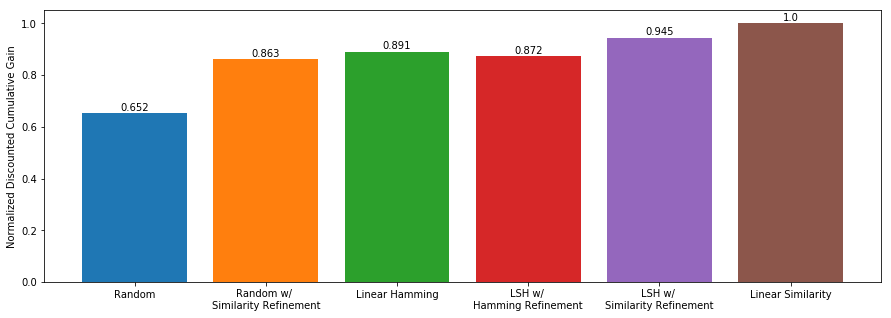

0.0015286850929260255


In [67]:
L = 4   #number of neighbors to make candidates
k = 10  #top-k nearest neighbors

t, ndgc = query_obj.time_and_compare(100, N_neighbor_candidates=L, k_report=k)
query_obj.ndgc_plot()
print(t, ndgc)

In [91]:
k = 10  #top-k nearest neighbors

Ls = [4] #number of neighbors to make candidates
bs = [200] #hash bits
es = [2.7] #error tolerance

Ls = [0, 2, 4, 8] #number of neighbors to make candidates
# bs = [20, 200, 600, 1000] #hash bits
# es = [4, 2.7, 2.1, 1.5] #error tolerance


ts = np.zeros((len(bs), len(es), len(Ls)))
ndgcs = np.zeros((len(bs), len(es), len(Ls)))
print("b e M L t ndgc")
for i,b in enumerate(bs):
    for j,e in enumerate(es):
        n = data.X.shape[1]
        M = round(2*n**(1/(1+e)))
        query_obj = query(data=data, queries_dataset=queries, hash_bits=b, 
                  permutations=M)
        
        for k,L in enumerate(Ls):
            t, ndgc = query_obj.time_and_compare(100, N_neighbor_candidates=L, k_report=k)
            print(b, e, M, L, t, ndgc)


b e M L t ndgc
200 2.7 20 0 0.0008691620826721192 nan
200 2.7 20 2 0.0009250998497009278 0.9277641569637152
200 2.7 20 4 0.0010942316055297851 0.9386387826885264
200 2.7 20 8 0.0016170477867126466 0.9562842610992675


---